# Études du dataset

In [7]:
library(readr)       # pour lire les CSV
library(dplyr)       # pour la manipulation
library(ggplot2)     # pour les graphiques
library(tidyr)       # pour le nettoyage
library(scales)      # pour la normalisation
library(caret)       # pour preprocessing
library(FactoMineR) # pour l'ACP
library(factoextra) # pour visualiser l'ACP

In [8]:
description <- read_delim("Descriptif_patients.csv", delim = ";")
radio_global <- read_delim("radiomiques_global.csv", delim = ";")
radio_multi <- read_delim("radiomiques_multislice_formatee.csv", delim = ";")

Rows: 147 Columns: 14
-- Column specification --------------------------------------------------------
Delimiter: ";"
chr (9): classe_name, Gender, Date_of_MRI, Date_of_surgery, Alpha_foetoprote...
dbl (4): patient_num, Local_relapse, Distant_relapse, Death
num (1): Age_at_disease

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 550 Columns: 148
-- Column specification --------------------------------------------------------
Delimiter: ";"
chr   (9): classe_name, temps_inj, diagnostics_Versions_PyRadiomics, diagnos...
dbl (137): patient_num, original_firstorder_10Percentile, original_firstorde...
lgl   (2): diagnostics_Configuration_Settings, diagnostics_Configuration_Ena...

i Use `spec()` to retrieve the full column specification for this data.
i Specify the column types or set `show_col_types = FALSE` to quiet this message.
Rows: 413 Columns: 1
-- Column specification ----

In [9]:
numeric_cols <- radio_multi %>%
  select(where(is.numeric))

radio_multi <- radio_multi %>%
  mutate(slice_zone = case_when(
    slice_num <= 33 ~ "Bas",
    slice_num <= 66 ~ "Milieu",
    TRUE ~ "Haut"
  ))

ERROR: Error in env_bind0(env, dots$named): variable names are limited to 10000 bytes


In [ ]:
ggplot(radio_multi, aes(x = original_firstorder_Entropy)) +
  geom_histogram(bins = 30, fill = "steelblue") +
  facet_wrap(~ slice_num, scales = "free_y") +
  labs(title = "Distribution d'Entropy par zone du foie",
       x = "Entropy", y = "Count")

ggplot(radio_multi, aes(x = original_firstorder_Mean)) + 
  geom_histogram(bins = 30, fill = "darkred", color = "black") +
  facet_wrap(~ slice_num, scales = "free_y") +
  labs(title = "Distribution de Mean par slice",
       x = "Mean", y = "Count")

ggplot(radio_multi, aes(x = original_firstorder_Skewness)) + 
  geom_histogram(bins = 30, fill = "darkgreen", color = "black") +
  facet_wrap(~ slice_num, scales = "free_y") +
  labs(title = "Distribution de Skewness par slice",
       x = "Skewness", y = "Count")

ggplot(radio_multi, aes(x = original_glcm_Contrast)) + 
  geom_histogram(bins = 30, fill = "orange", color = "black") +
  facet_wrap(~ slice_num, scales = "free_y") +
  labs(title = "Distribution de GLCM Contrast par slice",
       x = "GLCM Contrast", y = "Count")

ggplot(radio_multi, aes(x = original_glszm_ZoneEntropy)) + 
  geom_histogram(bins = 30, fill = "purple", color = "black") +
  facet_wrap(~ slice_num, scales = "free_y") +
  labs(title = "Distribution de GLSZM ZoneEntropy par slice",
       x = "GLSZM ZoneEntropy", y = "Count")

ggplot(radio_multi, aes(x = original_ngtdm_Complexity)) + 
  geom_histogram(bins = 30, fill = "goldenrod", color = "black") +
  facet_wrap(~ slice_num, scales = "free_y") +
  labs(title = "Distribution de NGTDM Complexity par slice",
       x = "NGTDM Complexity", y = "Count")

ggplot(radio_multi, aes(x = original_gldm_DependenceVariance)) + 
  geom_histogram(bins = 30, fill = "cyan4", color = "black") +
  facet_wrap(~ slice_num, scales = "free_y") +
  labs(title = "Distribution de GLDM DependenceVariance par slice",
       x = "GLDM DependenceVariance", y = "Count")

In [ ]:
df_summary <- radio_multi %>%
  group_by(classe_name, patient_num, temps_inj) %>%  # regrouper par cancer, patient et phase d'injection
  summarise(
    tumor_size = n(),    # compter le nombre de slices (lignes) = taille tumeur
    .groups = "drop"
  )

# Afficher un aperçu
print(df_summary)

# A tibble: 550 x 4
   classe_name patient_num temps_inj tumor_size
   <chr>             <dbl> <chr>          <int>
 1 CCK                   1 ART               39
 2 CCK                   1 PORT              44
 3 CCK                   1 TARD              44
 4 CCK                   1 VEIN              44
 5 CCK                   2 ART               11
 6 CCK                   2 PORT              11
 7 CCK                   2 TARD               4
 8 CCK                   2 VEIN              11
 9 CCK                   3 ART                4
10 CCK                   3 PORT               4
# i 540 more rows


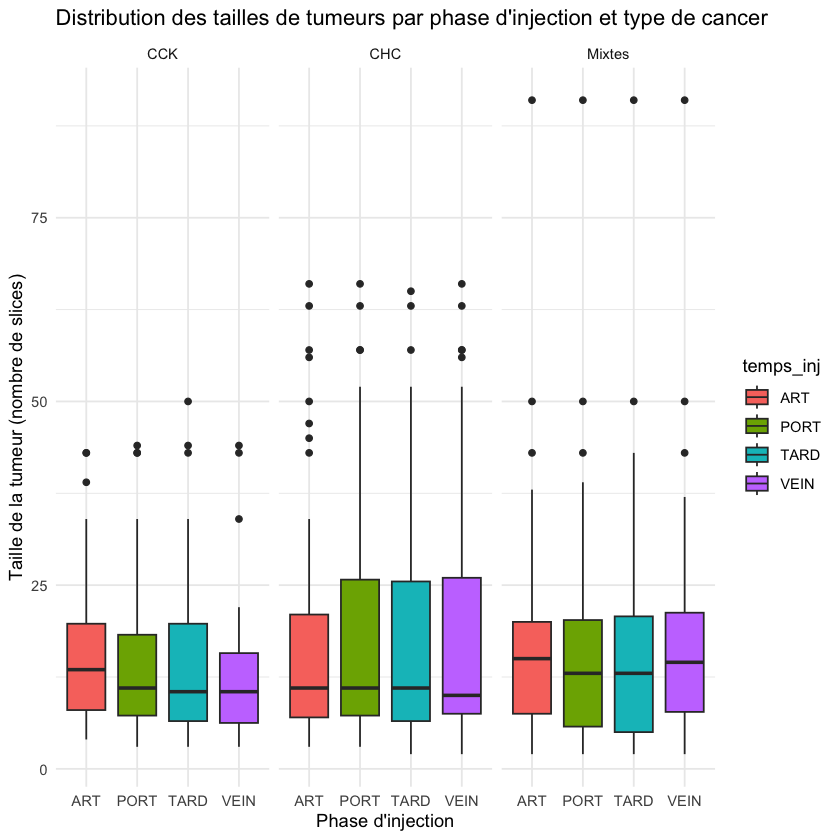

In [ ]:
ggplot(df_summary, aes(x = temps_inj, y = tumor_size, fill = temps_inj)) +
  geom_boxplot() +
  facet_wrap(~ classe_name) +  # pour voir par type de cancer
  labs(title = "Distribution des tailles de tumeurs par phase d'injection et type de cancer",
       x = "Phase d'injection",
       y = "Taille de la tumeur (nombre de slices)") +
  theme_minimal()

In [ ]:
df_summary %>%
  group_by(classe_name, temps_inj) %>%
  summarise(mean_tumor_size = mean(tumor_size)) %>%
  ggplot(aes(x = temps_inj, y = mean_tumor_size, group = classe_name, color = classe_name)) +
  geom_line() +
  geom_point() +
  labs(title = "Taille moyenne des tumeurs par phase et type de cancer",
       x = "Phase d'injection",
       y = "Taille moyenne (slices)") +
  theme_minimal()


ERROR: Error: object 'df_summary' not found


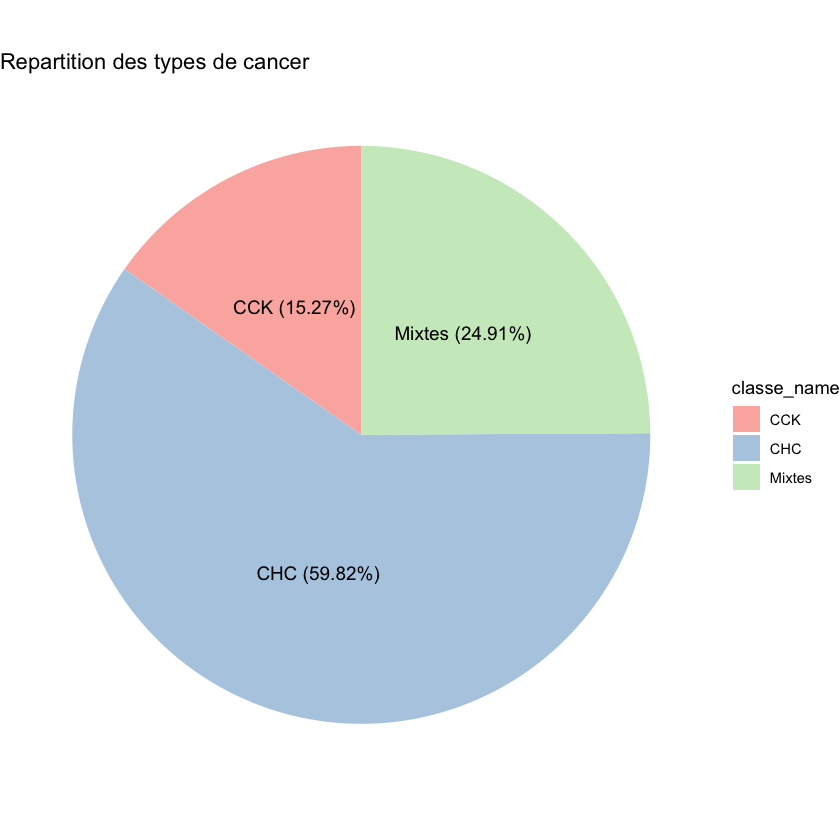

In [13]:
df <- radio_global

cancer_prop <- df %>%
  group_by(classe_name) %>%
  summarise(count = n()) %>%
  mutate(prop = round(100 * count / sum(count), 2),
         label = paste0(classe_name, " (", prop, "%)"))

# Camembert
ggplot(cancer_prop, aes(x = "", y = count, fill = classe_name)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y") +
  labs(title = "Repartition des types de cancer") +
  theme_void() +
  geom_text(aes(label = label),
            position = position_stack(vjust = 0.5),
            size = 4) +
  scale_fill_brewer(palette = "Pastel1")  # Palette douce

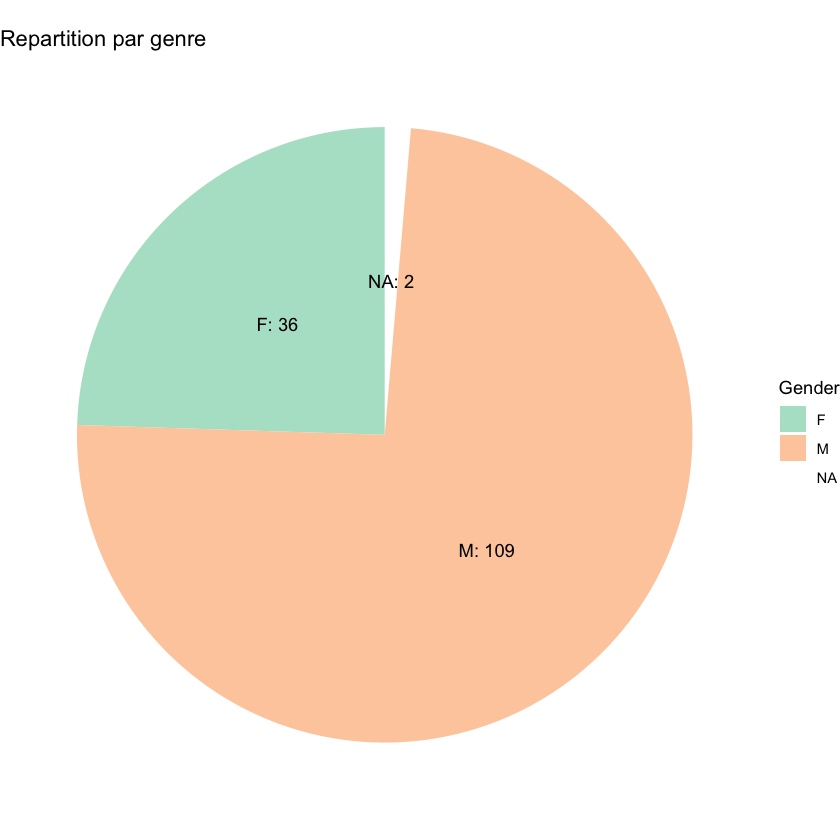

In [15]:
description %>%
  count(Gender) %>%
  ggplot(aes(x = "", y = n, fill = Gender)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y") +
  geom_text(aes(label = paste0(Gender, ": ", n)), position = position_stack(vjust = 0.5)) +
  labs(title = "Repartition par genre") +
  scale_fill_brewer(palette = "Pastel2") +
  theme_void()

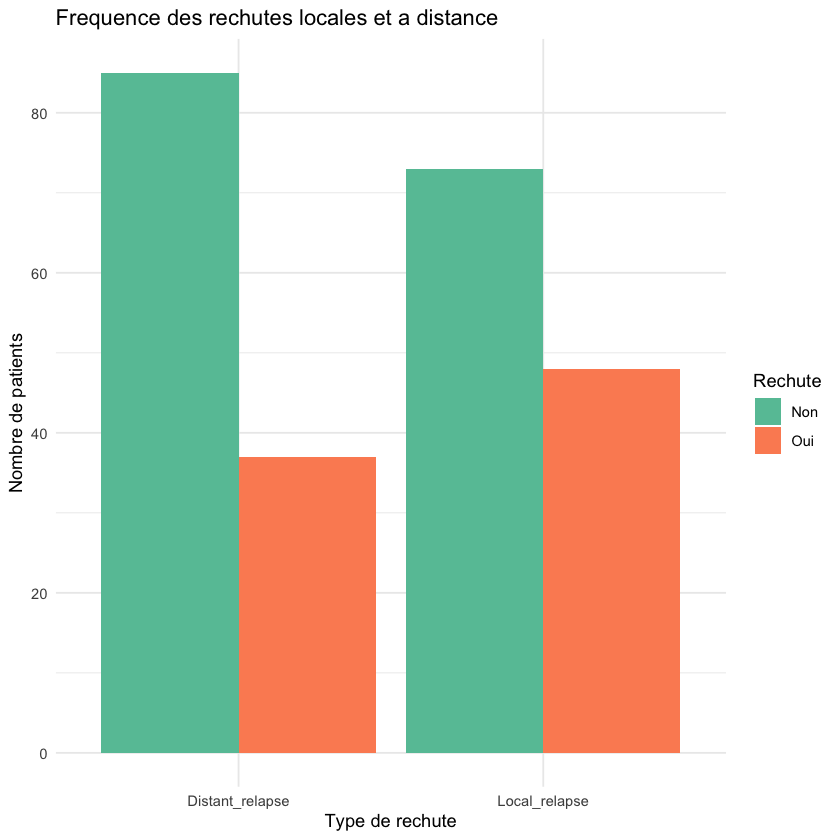

In [19]:
description %>%
  pivot_longer(cols = c(Local_relapse, Distant_relapse),
               names_to = "Type", values_to = "Rechute") %>%
  filter(!is.na(Rechute)) %>%
  mutate(Rechute = factor(Rechute, levels = c(0, 1), labels = c("Non", "Oui"))) %>%
  count(Type, Rechute) %>%
  ggplot(aes(x = Type, y = n, fill = Rechute)) +
  geom_col(position = "dodge") +
  labs(title = "Frequence des rechutes locales et a distance",
       x = "Type de rechute", y = "Nombre de patients", fill = "Rechute") +
  scale_fill_brewer(palette = "Set2") +
  theme_minimal()

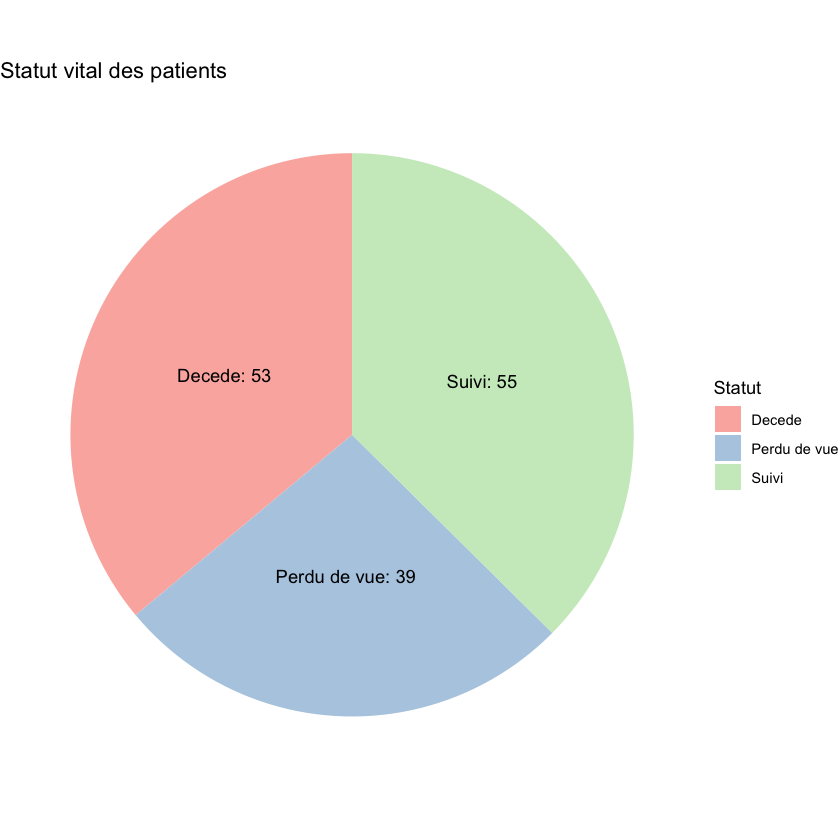

In [21]:
description %>%
  mutate(Statut = case_when(
    !is.na(Date_of_death) ~ "Decede",
    !is.na(Date_of_lost_of_FU) ~ "Perdu de vue",
    TRUE ~ "Suivi"
  )) %>%
  count(Statut) %>%
  ggplot(aes(x = "", y = n, fill = Statut)) +
  geom_bar(stat = "identity", width = 1) +
  coord_polar("y") +
  labs(title = "Statut vital des patients") +
  geom_text(aes(label = paste0(Statut, ": ", n)), position = position_stack(vjust = 0.5)) +
  scale_fill_brewer(palette = "Pastel1") +
  theme_void()